# Oppgave 1: Dokumentvektorer
I denne oppgaven skal vi se på hvordan vi kan representere dokumenter som vektorer som kan brukes for visualisering og klassifisering

In [ ]:
from collections import Counter, defaultdict
import nltk
from nltk.corpus import gutenberg
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
nltk.download('gutenberg')
nltk.download('stopwords')
nltk.download('punkt')

## Korpus, tokens og vokabular  
Et *korpus* er en samling av tekster. F.eks Gutenberg-korpuset.  
*Tokens* er ord (eller sub-ord), og tokenisering er en del av preprosesseringen for de aller fleste språkteknologioppgaver.  
*Vokabularet* til et datasett eller en modell er antall **unike** tokens.   

In [ ]:
# Eksempelkode
ids = gutenberg.fileids()
blake_poems = ids[4]
gutenberg.words(blake_poems)


### 1. Hent ut titlene på bøkene som er skrevet av Jane Austen og William Shakespeare.   
    Bruk gutenberg.fileids() for å hente ut titlene. Disse titlene blir vår samling som vi skal jobbe videre med.  
    Hvor mange bøker er det? 

In [ ]:
# Din kode her

### 2. Bruk gutenberg.words for å hente ut selve tekstene. Observer at tekstene allerede er *tokenisert*.  

    Hvor mange tokens er det i hver tekst?  
    Hvor mange unike tokens er det i hver tekst?
    Hvor stort er vokabularet i samlingen vår?  
    Sammenlikn størrelsen på vokabularet med totalt antall tokens. 
    Hvilke 5 tokens forekommer oftest? 
https://en.wikipedia.org/wiki/Zipf's_law

In [ ]:
# Din kode her

## Bag-of-Words-modellen
Bag-of-words (BoW) er en måte å representere dokumenter (=tekster) på.  
Vi ser bort ifra strukturen og ordrekkefølge i setninger, og lar et dokument representeres som mengden av ord som finnes i dokumentet. 


Eksempel: 
```
"Fisk er en type dyr"                   {"Fisk", "en", "er", "dyr", "type"}
"Fisk er godt"                          {"Fisk", "er", "godt"}
"Hester er dyr"                         {"Hester", "er",  "dyr"}
```
Her har vi fire tekster, og mengden av tokens disse består av. 

For å kunne lage dokumentvektorer, lar vi hver dimensjon/feature i dokumentvektoren svare til ett ord i vokabularet.  

Eksempel:
```
                                'godt', 'type', 'dyr', 'Hester', 'Fisk',   
"Fisk er en type dyr"             0        1      1       0        1     
"Fisk er godt"                    1        0      0       0        1     
"Hester er dyr"                   0        0      1       1        0     
```
Kalles en dokument-ord matrise (eller document-term matrix )

Legg merke til at "en" og "er" er fjernet fra matrisen.
Å fjerne funksjonsord som ikke har så mye mening i seg selv, er et grep for å:  
1. minske vokabularet, og dermed vektorrommet, og dermed regnekraften som trengs  
2. fjerne støy, da funksjonsord typisk forekommer i alle dokumenter  
     
Vi kaller ord som skal fjernes for *stoppeord* eller *stop words*

### 1. Indekser vokabularet
    Lag en indekser over hvert token i vokabularet.
    Hvert unike token skal ha en unik indeks, og indeksene skal gå fra 0 til størrelsen av vokabularet.
    Hvilken indeks har ordet "Julius"? (bør kunne hentes i konstant tid med indexer["Julius"], evt indexer("Julius"))

In [ ]:
# Din kode her

### 2. Lag og visualiser dokumentvektorer
    Bruk indekseren og bøkene for å lage dokumentvektorer for hver av bøkene i samlingen vår.  
    Du kan lage one-hot vektorer (bare binærtall), og/eller vektorer der tallet i hver dimensjon er antall ganger det ordet forekommer i teksten. (lurt å bruke collections.Counter i så fall)
    Visualiser dokumentvektorene.  
    Hva ser du?


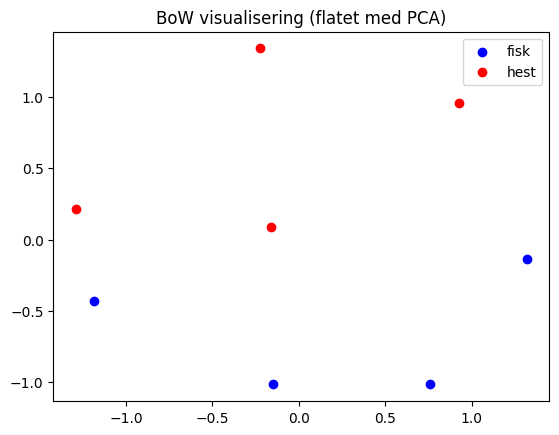

In [25]:
# Eksempel

fisk_docs = ["fisk er en type dyr", "fisker fisker ikke fisk", "fisk er godt", "jeg fisker med stang"]
hest_docs = ["hester er dyr", "jeg har en dyr hest", "hester har fine sko", "ponni er en type hest"]
docs = fisk_docs + hest_docs

voc = set(" ".join(docs).split())
index = {w: i for i, w in enumerate(voc)}

# One-hot enkodede BoW-vektorer
vecs = np.zeros((len(docs), len(voc)))
for i, doc in enumerate(docs):
    s = doc.split()
    for w in s:
        vecs[i][index[w]] = 1

# Visualisering
pca = PCA(n_components=2)
vecs_2d = pca.fit_transform(vecs)
x, y = zip(*vecs_2d)

i = len(fisk_docs)

plt.scatter(x[:i], y[:i], c="blue", label="fisk")
plt.scatter(x[i:], y[i:], c="red", label="hest")
plt.title("BoW visualisering (flatet med PCA)")
plt.legend()

In [ ]:
# Din kode her

### 3. Bonusoppgave
    Eksperimenter med forskjellige måter å representere dokumentvektorene.  
    Du kan f.eks:
- fjerne stoppeord
- fjerne non-word-tokens (som tegnsetting)
- la vokabularet ignorere små/store bokstaver
- vekte ordene med tf-idf (https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [ ]:
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words('english')
"[" in punctuation

# Oppgave 2: Ordvektorer og word embeddings

## The distributional hypothesis og distributional semantics

"Meaning is use" (Wittgenstein, 1953)  
"You shall know a word by the company it keeps"  (Firth, 1957)  
"The meaning of entities, and the meaning of grammatical relations
among them, is related to the restriction of combinations of these
entities relative to other entities" (Harris, 1968)  

https://en.wikipedia.org/wiki/Distributional_semantics  
https://www.uio.no/studier/emner/matnat/ifi/IN2110/v23/foiler/05_ordvektorer_2023.pdf

Altså: Betydningen til et ord kan finnes ved å se på ordene det omgås med, *konteksten* til ordet.

Eksempel:  
 
    "Damen drikker en kopp kaffe"  
    "Jens drikker en kopp te"  
    "Jens drikker et glass vann"  
    "Hunden drikker vann"  

Grammatisk "riktig", men semantisk feil setning:  
"Jeg drikker en stol"  
"Stol" vil (så og si) aldri være objekt til verbet "drikker". 

##  Term-term matriser og ordvektorer
Vi kan lage ordvektorer ved hjelp av en term-term matrise. (også kalt *co-occurence matrix* eller *term-context matrix*)  
Da teller vi opp hvor mange ganger de forskjellige ordene i vokabularet forekommer sammen, altså er i samme kontekt.    
Størrelsen på *kontekstvinduet* er hvor mange ord bakover/forover vi henter ut konteksten.

Hvis størrelsen på kontekstvinduet er 2, vil vi få denne term-term-matrisen fra eksemplene over:

              'Damen', 'Hunden', 'Jens', 'drikker', 'kopp', 'glass', 'kaffe', 'te', 'vann'  
    'Damen'       0        0       0        1          1      0         0       0       0  
    'Hunden'      0        0       0        1          0      0         0       1       1   
    'Jens'        0        0       0        2          1      1         0       0       0  
    'drikker'     1        1       2        0          2      1         1       1       2  
    'kopp'        1        0       1        2          0      0         1       1       0       
    'glass'       0        0       1        1          0      0         0       0       1      
    'kaffe'       0        0       0        1          1      0         0       0       0  
    'te'          0        0       0        1          1      0         0       0       0  
    'vann'        0        1       1        2          0      1         0       0       0  

Hver rad/kolonne her er vektoren for det gjeldende ordet  

### 1. Lag en term-term matrise for ordene i vår samling.  
    Du kan velge å fjerne stoppeord og/eller tegnsetting, husk da at det må fjernes fra setningene *før* du teller kontekstordene. (Husk også å ikke inkludere stoppeordene i vokabularet) Du kan også velge å la vokabularet være case insensitive   
    La størrelsen på kontekstvinduet være 3 (på hver side av ordet), men ikke gå utenfor setningsgrenser. (Bruk gutenberg.sents istedenfor words)

In [ ]:
# Eksempelkode
sent = gutenberg.sents(ids[0])[0]

sent

Tokensene i konteksten til '[' er 'Emma', 'by' og 'Jane'.  
Tokensene i konteksten til 'Jane' er '[', 'Emma', 'by', 'Austen', '1816' og ']'. 

In [ ]:
# Din kode her

### 2. Finn likeste ord
Nå har vi vektorer som representerer betydningen til de forskjellige ordene. 

Hvis vi lar hver feature i ordvektorene svare til en dimensjon i et høydimensjonalt rom, kan vi måle avstanden mellom to vektorer med euklidsk avstand (https://en.wikipedia.org/wiki/Euclidean_distance#Higher_dimensions). Vi kan også måle likheten mellom to vektorer med cosinus-likhet (https://en.wikipedia.org/wiki/Cosine_similarity). 

For å regne ut disse er det lurt å *normalisere* vektorene, det vil si å gjøre dem til enhetsvektorer ved å dele verdien i hver dimensjon på lengden av vektoren (https://mathworld.wolfram.com/NormalizedVector.html)  
Gitt at vektorene er normalisert, kan man regne ut cosinus-likheten mellom to vektorer med prikkprodukt. 

    Lag en funksjon som regner ut avstanden eller likheten mellom to vektorer.

    Bruk ordvektorene og vektorrommet til å finne de 10 likeste* ordene til følgende ord:
- Emma
- George
- lovely
- King

    Hva ser du?

*Husk at hvis du bruker euklidsk avstand, så betyr lavere tall likere ord (avstanden mellom en vektor og seg selv er 0), og hvis du bruker cosinus-likhet så betyr høyere tall likere ord (cosinus-likheten mellom en vektor og seg selv er 1.

In [ ]:
# Din kode her

### 3. Finn noen vanlige ord som ikke er i vokabularet

In [ ]:
# Din kode her

### 4. Bonusoppgave
    Lag separate ordvektorer basert på Austen sine bøker og Shakespeare sine bøker.   
    (Altså, lag én term-term matrise for Austen-bøkene og én for Shakespeare-bøkene)    
    Finn noen ord som forekommer i begge vokabularene, og se om det er store forskjeller på de 10 likeste ordene fra hvert sett av bøker.  

In [ ]:
# Din kode her

## Word embeddings
Ordvektorene vi har laget nå er veldig *sparse*: for et gitt ord vil mesteparten av tallene i vektoren være 0.  
Vi så også at det er vanlige ord som vi ikke har vektorer for, og at vektorlengden vil øke linjært med vokabularet.  


I steden for å lage ordvektorer basert på telling av forekomster, kan man trene nevrale nettverk på ord og kontekst, og så bruke vektene til nettverket som representasjoner for ordene. Da kan vi bestemme dimensjonene til ordvektorene, siden det samsvarer med antall noder i nettverket, og vi får *dense* vektorer (korte med få 0-er). Vi kaller disse ordvektorene for word embeddings.

Noen enkle eksempler på algoritmer for å lage word embeddings er å trene nettverk på å predikere et ord gitt sin egen kontekst (Continuous-Bag-of-Words), eller til å predikere kontekten gitt et ord (Skip-Gram).  

Siden mer data > bedre resultater, vil man typisk vil man bruke word embeddings som noen andre har trent på enorme corpora. 

Les mer:  
Cbow og skip-gram: (Google, 2013: https://arxiv.org/abs/1301.3781)  
GloVe: (Stanford, 2014: https://nlp.stanford.edu/projects/glove/)


### 1. Finn de 10 likeste ordene til emma, george, lovely og king ved hjelp av Stanford sine GloVe-vektorer 

In [ ]:
import gensim.downloader

glove_model = gensim.downloader.load('glove-wiki-gigaword-300')

In [ ]:
glove_model.most_similar("sheep")

In [ ]:
# Din kode her

### 2. Finn de 10 likeste ordene til "bow"
    Hva ser du? 
    Hvordan forklarer du dette?

In [ ]:
# Din kode her

### 3. Bonus
    Tren et lite nettverk på å produsere neste ord gitt de x forrige med disse vektorene og bøkene i samlingen vår.  
    Du kan legge til spesielle start- og slutt-tokens på begge ender av hver setning (<sos> og <eos> feks)  
    Nå kan du bruke dette nettverket til å generere tekst (start genereringen med start-token, og slutt å generere når modellen predikerer slutt-token)

In [ ]:
# Din kode her

# Oppgave 3: Contextualized embeddings, tranformers og LLMs

## Contextualized embeddings
Siden (det som ser ut som) samme ord, kan ha forskjellige betydninger, fant man på *contextualized embeddings*.  
Da vil ordet "bow" i setningene "Legolas picked up his bow" og "The waiter wore a black bow" representeres av forskjellige vektorer.  

Konseptet med contextualized embeddings ble introdusert med Paragraph Vector/Doc2Vec, en arkitektur for dokument-embeddings (2014, Stanford: https://arxiv.org/abs/1405.4053)

En kjent modell for contextualized embeddings er ELMo (Embeddings from Language Models). Den ble publisert i 2018 (paper: https://arxiv.org/abs/1802.05365) og er basert på BiDirectional LSTMs*) 

*LSTM = Long Short Term Memory, en type Recurrent Neural Network (RNN) som kan "huske" relativt lang kontekst (spesialdesinget for å være bedre enn vanilla RNN på vanishing gradients)

### 1. Visualiser ELMo embeddings
I denne oppgaven skal vi bruke ELMo for å se hvordan vektorrepresentasjonen til et flertydig ord ser ut i forskjellige kontekster.  

    Finn alle setningene i samlingen vår hvor ordet "bow" forekommer. 
    Bruk ELMo til å hente ut word embeddingen for "bow" i hver kontekst, og plott disse med ditt favorittverktøy 

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

elmo = hub.load("https://tfhub.dev/google/elmo/3").signatures["tokens"]

In [ ]:
# Fyll inn kode her:
# TODO: 
# Finn setninger - (bruk de tokeniserte setningene vi fikk fra gutenberg.sents)
# Pad setningene med "" på slutten slik at alle listene med ord er like lange
# Spar på lengdene på de originale setningene (altså antall tokens uten padding), sånn at paddingen ikke blir en del av vektorene

# padded_sents = de paddede sentingene, input_lens er lengden av de faktiske setningene 
embeddings_tensors = elmo(tokens=tf.constant(padded_sents), sequence_len=tf.constant(input_lens))
indices = [sent.index("bow") for sent in sents]
embs = [emb[i] for i, emb in zip(indices, embeddings_tensors["elmo"])]

# TODO: Visualiser embeddingsene i et scatterplot 

## Transformer-arkitekturen og Large Language Models (LLMs) (to be continued)
En annen kjent modell for contextualized word embeddings er BERT (2018, paper: https://arxiv.org/abs/1810.04805).  
Basert på encoder-delen av transformer-arkitekturen*, lager BERT contextualized word embeddings.  
BERT er trent på bl.a masked language modelling, og kan brukes til å klassifisere sekvenser (ordklasser, dependensgrafer, entitetsekstrahering). 

*Transformers-arkitekturen ble presentert i det nå legendariske paperet Attention is all you need (2017, https://arxiv.org/abs/1706.03762)  
Mye mer kontekst kan "huskes" (det går kanter mellom hvert par av tokens) og den er ikke sekvensiell på samme måte som LSTMer som betyr at det er lett å parallelisere trening og inference  

GPT-modellene er også basert på transformers. Og T5 (https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html) (så og si all nyere språkteknologi)

Jeg rakkk ikke mer, vi får ta resten senere!!!   
Dypere om transformers og multimodale modeller kommer neste gang kan vi si

Anbefaler Andrey sin talk her:  
https://www.youtube.com/watch?v=mtM6D2ySME8  
slides: https://www.nora.ai/cuttingedgeai/cuttinedge-ai-february/presentations/06---andrey-kutuzov---lm_chatgpt.pdf  